### 下载数据

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml/raw/master/datasets/housing"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
#     urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

### 加载数据

In [2]:
import pandas as pd

# 返回一个Pandas.DataFrame 对象
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
# 查看数据前五行信息
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 数据信息

In [3]:
# 快速查看数据描述，总行数、每个属性的类型和非空值的数量
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# value_counts()查看该项中有哪些类别，每个类别数量
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
# describe()方法展示了数值属性的概括
# 空值被忽略了
# 信息包括数量、均值、标准差、最小值、25%分位数、最大值
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


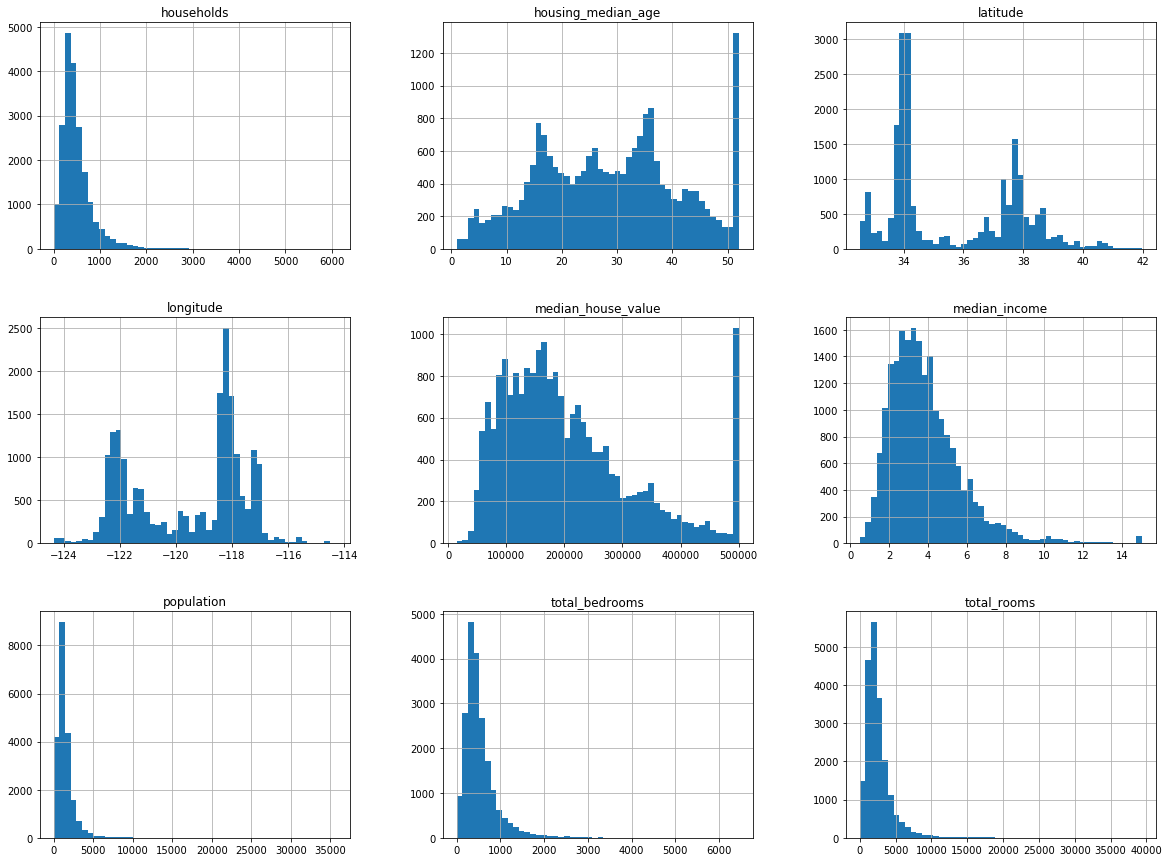

In [6]:
# 对属性进行柱状图分析
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### 分离数据构造训练、测试数据

In [7]:
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), ':', len(test_set))

16512 : 4128


In [8]:
# 虽然设置随机种子，但在更新数据集之后依然不能保证测试集相同，使用唯一id构建hash表
import hashlib
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [9]:
# 索引做id
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')
print(len(train_set), ':', len(test_set))

16362 : 4278


In [10]:
# 经纬度做id
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')
print(len(train_set), ':', len(test_set))

16267 : 4373


In [11]:
# sklearn自带的切分数据
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), ':', len(test_set))

16512 : 4128


In [12]:
# 考虑属性，进行分层切分，根据收入进行，
# 根据收入进行分层ceil()舍入取整数
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
# 将收入分为5类
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

housing['income_cat'].head(20)

0     5.0
1     5.0
2     5.0
3     4.0
4     3.0
5     3.0
6     3.0
7     3.0
8     2.0
9     3.0
10    3.0
11    3.0
12    3.0
13    2.0
14    2.0
15    2.0
16    2.0
17    2.0
18    2.0
19    2.0
Name: income_cat, dtype: float64

In [13]:
# 调用sklearn 中自带函数进行分层切分（df.loc(index)，根据index进行切片）
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print(len(strat_train_set), ':', len(strat_test_set))

16512 : 4128


In [15]:
# 分层切分之后对比一下原数据、分层切分、随机切分的分布
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


In [16]:
# 从数据中删除income_cat使数据恢复
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

### 数据探索和可视化、发现规律

In [17]:
# 创建数据副本，以免损伤训练集
housing = strat_test_set.copy()

##### 地理数据可视化

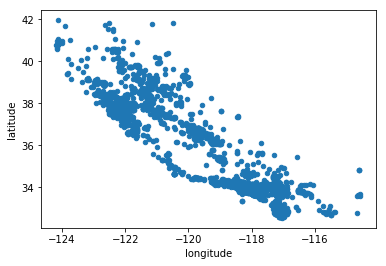

In [18]:
# 根据经纬度进行数据可视化
housing.plot(kind='scatter', x='longitude', y='latitude')

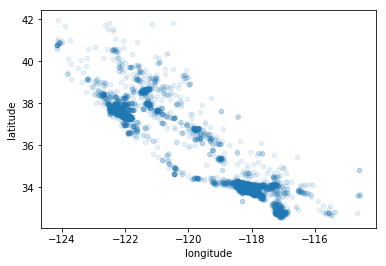

In [19]:
# 根据经纬度进行数据可视化
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

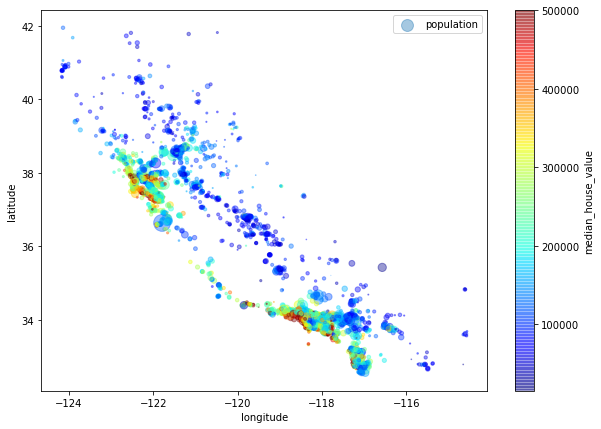

In [20]:
# 查看房价与经纬度、人口的关系
# 圆圈半径表示人口(s)，颜色代表房价(c)，使用预先定义的jet的颜色图(cmp)，从蓝色(低价)到红色(高价)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"] / 100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

### 查找关联

In [21]:
# corr()计算每对属性间的标准相关系数（皮尔逊相关系数）只能测量线性关系，非线性关系忽略
corr_matrix = housing.corr()
# 查看每个属性和房价中位数的关联度，越接近1正相关，接近-1负相关，接近0没有线性相关
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691831
total_rooms           0.131435
housing_median_age    0.071357
households            0.071242
total_bedrooms        0.057568
population           -0.016033
longitude            -0.039987
latitude             -0.150124
Name: median_house_value, dtype: float64

另一种检测相关性系数的方法是Pandas中的`scatter_matrix()`函数，画出每个数值属性对每个其它数值属性的图，现在11个数值属性，可以得到`9*9=81`张图，只关注几个和房价中位数有关的属性。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021AAA33DC18>,
      dtype=object)

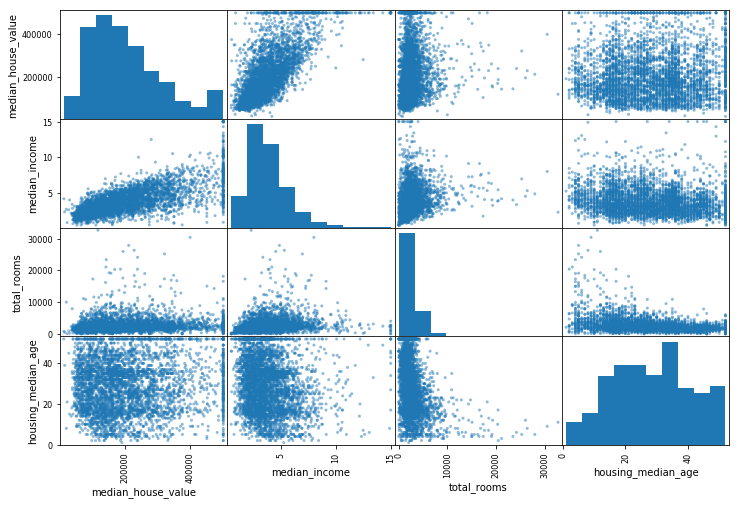

In [22]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

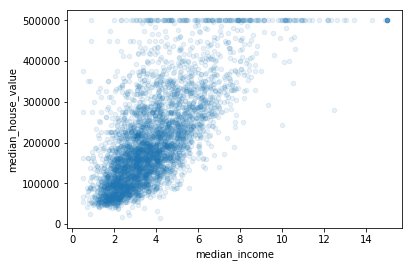

In [23]:
# 最有关系的是收入，放大收入
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

### 属性组合实验